# Text Representation

In [30]:
import pandas as pd

In [31]:
pip install --upgrade altair

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Fetch preprocessed data
model_data = pd.read_csv("data/keywords.csv")
model_data.head()

,Id,Name,Language,keywords
0,1020396,the gospel of john,eng,francis_j._moloney michael_glazier eng gospel...
1,1073868,hanslick on the musically beautiful: sixteen l...,eng,geoffrey_payzant 1-877275-49-2 eng musikalisc...
2,1038843,never tell your name,eng,josie_levy_martin 1st_book_library eng nun me...
3,1021643,the reign of law,eng,james_lane_allen 1st_world_library eng nurser...
4,1019884,cousin phillis,eng,elizabeth_gaskell 1st_world_library eng railw...


---
### Vectorize the keywords summary using TF-IDF
- Convert the keywords for each book into a numeric vector, based on the frequency of each word in the book's keywords
- Keep token pattern such that tokens with underscore are not ignored.
- Remove tokens occuring less than 3 times or occur in more than 60% of the documents (common tokens).
- Remove english language stop words

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8', 
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(model_data["keywords"])

In [34]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[1:100])

['1609' '1611' '1692' '1773' '1775' '1776' '1781' '1783' '1787' '1789'
 '1797' '1800s' '1803' '1805' '1806' '1812' '1814' '1815' '1830' '1830s'
 '1832' '1836' '1837' '1838' '1839' '1840' '1840s' '1846' '1848' '1850'
 '1850s' '1852' '1854' '1857' '1860' '1860s' '1861' '1862' '1863' '1864'
 '1865' '1867' '1870' '1876' '1880' '1880s' '1881' '1886' '1889' '1890'
 '1890s' '1892' '1896' '1900' '1900s' '1902' '1903' '1910' '1912' '1914'
 '19141918' '1915' '1916' '1917' '1918' '1919' '1920' '1920s' '1921'
 '1923' '1925' '1927' '1929' '1930' '1930s' '1931' '1932' '1933' '1937'
 '1938' '1939' '1940' '1940s' '1941' '1942' '1943' '1944' '1945' '1946'
 '1947' '1948' '1949' '1950' '1950s' '1954' '1956' '1958' '1959' '1960s']


In [35]:
# Lets find representation of a new book's keywords in the existing vocabulary space
tfidf.transform(["looking for alaska by john green"]).toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
tfidf_encoding.toarray().shape

(29394, 12881)

---
### Visualize the TF-IDF word embeddings

In [37]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=model_data["Name"], columns=tfidf.get_feature_names_out())

In [38]:
# Find top 50 books with maximum tf-idf total score
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
del tfidf_df["total"]

In [39]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[100:150,25:].copy()
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
display(tfidf_df_preview)

,book,term,tfidf
379136,23 ways to mess up valentine's day (willimena ...,jump_at_the_sun,0.407913
384966,23 ways to mess up valentine's day (willimena ...,valerie_wilson_wesley,0.395556
374742,23 ways to mess up valentine's day (willimena ...,celebrate,0.381878
384962,23 ways to mess up valentine's day (willimena ...,valentine,0.381878
384963,23 ways to mess up valentine's day (willimena ...,valentines,0.381878
...,...,...,...
613148,"white lies (arcane society, #2)",piatkus_books,0.359916
613598,"white lies (arcane society, #2)",psychic,0.328203
604232,"white lies (arcane society, #2)",1839,0.000000
604233,"white lies (arcane society, #2)",1840,0.000000


In [40]:
# Find books with term "london"
tfidf_df_preview[tfidf_df_preview['term'].str.contains('london')]

,book,term,tfidf


In [41]:
# Find book names with word mystery
tfidf_df_preview[tfidf_df_preview['book'].str.contains('mystery')].head(5)

,book,term,tfidf
411874,the father hunt: a nero wolfe mystery,amys,0.413906
424062,the father hunt: a nero wolfe mystery,wolfes,0.407990
412245,the father hunt: a nero wolfe mystery,audiogo,0.380141
412062,the father hunt: a nero wolfe mystery,archie,0.374596
411870,the father hunt: a nero wolfe mystery,amy,0.355772


In [42]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]
    
    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())    
tfidf_vec.iloc[0:5]

,book,term,tfidf
379136,23 ways to mess up valentine's day (willimena ...,jump at the sun,0.407913
384966,23 ways to mess up valentine's day (willimena ...,valerie wilson wesley,0.395556
374742,23 ways to mess up valentine's day (willimena ...,celebrate,0.381878
384962,23 ways to mess up valentine's day (willimena ...,valentine,0.381878
384963,23 ways to mess up valentine's day (willimena ...,valentines,0.381878


- For each book, we will rank its terms based on its tf-idf score. Term with maximum score within the document will get rank 1.
- Two or more terms may have same tf-idf score, such terms will overlap in the heatmap.

In [43]:
import altair as alt
alt.renderers.enable('mimetype')
grid = alt.Chart(tfidf_vec).encode(
    x = 'rank:O',
    y = 'book:N'
).transform_window(
    rank = "dense_rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["book"],
)
heatmap = grid.mark_rect(size=5).encode(
    alt.Color('tfidf:Q', scale=alt.Scale(scheme='redpurple'))
)
text = grid.mark_text(align='center', baseline='middle', lineBreak='').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
(heatmap+text).properties(width = 800)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


---
### Cosine Similarity between books vector representation

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

In [45]:
# Preview Similarity Matrix
book_cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

MemoryError: Unable to allocate 6.44 GiB for an array with shape (29394, 29394) and data type float64

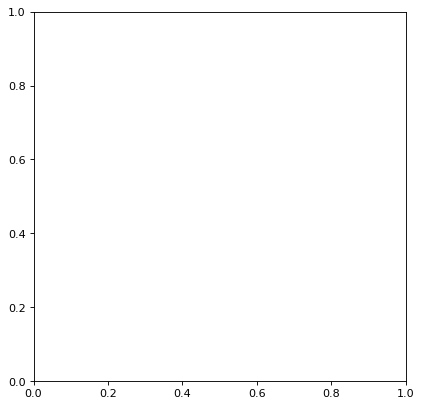

In [46]:
# Vidualize similarity between books
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6), dpi=80)
plt.spy(book_cosine_sim, precision = 0.1, markersize = 0.04)
plt.tight_layout()
plt.show()


---
### Recommendation
- Given a book name, find top n similar books based on cosine similarity score.
1) Series Information
2) Other Books In Numbered Series
3) Theme
4) Author

In [47]:
books = pd.Series(model_data['Name'])

def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    # get index of the imput book
    input_idx = books[books == book_name].index[0]   
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)
    
    books_list = list(books)
    recommended_books = [books[i] for i in top_n_books_idx]
        
    return recommended_books

In [48]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)"))
display(recommend_books_similar_to("the eastland disaster (images of america: illinois)", 5))

# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)"))
display(recommend_books_similar_to("the majolica murders (antique lover, #5)", 5))

print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)"))
display(recommend_books_similar_to('the practice of programming (addison-wesley professional computing series)', 5))

print("\n\033[1m{}\033[0m".format("Recommendation (Author: Dean Koontz) based on the read: Cold Fire"))
display(recommend_books_similar_to("cold fire",5))

Recommendation (Series Information) based on the read: The Eastland Disaster (Images of America: Illinois)


['forgotten chicago (images of america: illinois)',
 'mount carmel and queen of heaven cemeteries (images of america: illinois)',
 "chicago's southeast side (images of america: illinois)",
 'st. charles: culture and leisure in an all-american town (images of america: illinois)',
 'the great fire of london 1666 (all about...)']


Recommendation (Numbered Series) based on the read: The Majolica Murders (Antique Lover, #5)


['four on the floor (antique lover, #4)',
 'caught dead',
 'the weedless widow (antique lover, #2)',
 'the marriage casket (antique lover, #3)',
 'how to build outdoor structures']


Recommendation (Theme: Programming) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)


['unix for the mainframer: the essential reference for commands, conversions, tcp/ip',
 'smalltalk with style',
 'the c++ programming language',
 'sams teach yourself beginning programming in 24 hours',
 'data structures & other objects using java']


Recommendation (Author: Dean Koontz) based on the read: Cold Fire


['the big island',
 'papa jack: jack johnson and the era of white hopes',
 'darkfall',
 'keeping watch: heart of the night\\accidental bodyguard',
 "a mother's gift"]

In [49]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

# Assuming you have a column 'Label' in your model_data dataframe indicating the category of each book

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model_data['keywords'], model_data['Label'], test_size=0.2, random_state=42)

# Create a pipeline with TF-IDF vectorizer and a classifier (e.g., Logistic Regression)
model = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', min_df=3, max_df=0.6, stop_words='english', encoding='utf-8', token_pattern=r"(?u)\S\S+")),
    ('classifier', LogisticRegression())
])

# Train the model
model.fit(X_train, y_train)

# Save the model to an h5 file
joblib.dump(model, 'text_classification_model.h5')


ImportError: cannot import name 'joblib' from 'sklearn.externals' (c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\__init__.py)